# Imports and Function Definitions

## Imports

In [ ]:
# Imports
import pandas as pd
import numpy as np
import sys

from datetime import datetime as dt

# Scikit-learn
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from lightgbm import LGBMClassifier
from imblearn.combine import *
from imblearn.over_sampling import *
from imblearn.under_sampling import *
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import *
from sklearn.calibration import CalibratedClassifierCV

from scipy.stats import *

import missingno as msno
import prince

import seaborn as sns
import matplotlib.pyplot as plt

## Function: Calculate Missing Value Pct

In [ ]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

# Dataset

## Read Dataset

Read training data and submission data. Change label to numerical.

In [ ]:
df = pd.read_csv('train.csv')
df['DC201'] = [1 if i == 'Layak Minum' else 0 for i in df['DC201']]

df_test = pd.read_csv('test.csv')
df.head()

# Overall Overview

## Overall: Correlation

Seems that DC109 has very high correlation with DC205. We can drop either one OR use PCA to reduce dimensions.

In [ ]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,id,DC024,DC025,DC205,DC206,DC207,DC208,DC209,DC210,DC211,DC212,DC213,DC214,DC215,DC216,DC217,DC219,DC220,DC226,DC230a,DC230b,DC232,DC232b,DC235,DC237,DC237a,DC237b,DC237c,DC237d,DC237e,DC237f,DC241,DC242,DC244,DC246,DC252,DC270a,DC109,DC142a,DC201
id,1.000000,0.974972,0.101476,0.039126,-0.073837,-0.053239,-0.149891,-0.113275,-0.072947,-0.142769,-0.054095,-0.150405,-0.016839,-0.122800,0.039935,0.012023,-0.006929,-0.026369,0.031266,0.086452,-0.037726,-0.014600,0.035597,0.267302,0.031720,0.020389,0.009859,0.132599,-0.008310,-0.005245,0.111251,0.101751,-0.154744,0.148014,0.089435,0.038593,-0.151877,0.067607,-0.003896,-0.011420
DC024,0.974972,1.000000,0.115967,0.050238,-0.073412,-0.073789,-0.158540,-0.109523,-0.110910,-0.153732,-0.053324,-0.151308,-0.009990,-0.159182,0.029100,0.015285,-0.009633,-0.038624,0.026520,0.102953,-0.040812,-0.018593,0.039849,0.268678,0.028227,0.021443,0.010874,0.122498,-0.006412,-0.004637,0.095104,0.095020,-0.158949,0.162899,0.086701,0.036136,-0.171151,0.075237,-0.009484,-0.024560
DC025,0.101476,0.115967,1.000000,0.249896,-0.154560,-0.128228,-0.228847,-0.324782,-0.124580,-0.151809,-0.174184,-0.167822,-0.063258,-0.149274,-0.026840,-0.052370,-0.016371,0.054666,0.003595,0.138995,-0.085915,-0.111371,0.021138,0.262525,0.244903,0.233396,0.000237,0.113192,0.004654,-0.002844,0.130321,0.122635,-0.014153,0.433814,0.340383,0.042213,-0.074408,0.268028,-0.072236,-0.256544
DC205,0.039126,0.050238,0.249896,1.000000,-0.222417,-0.093648,-0.286602,-0.333856,-0.140023,-0.218461,-0.163972,-0.216568,-0.067192,-0.168920,-0.188297,-0.076392,0.016731,-0.013647,0.058311,0.230626,-0.106181,-0.158554,0.021744,0.217918,0.107267,0.101865,0.011114,0.026510,-0.004451,-0.002786,0.044352,0.104596,-0.063276,0.092780,0.092391,0.012745,-0.411133,0.879477,-0.127207,-0.270813
DC206,-0.073837,-0.073412,-0.154560,-0.222417,1.000000,0.060063,0.351162,0.211296,0.091119,0.205554,0.074703,0.192204,0.094601,0.196780,0.087942,0.064457,-0.019932,0.012345,-0.062729,-0.114374,0.084267,0.085329,-0.020945,-0.144873,-0.063726,-0.062952,0.006800,-0.116366,-0.001758,0.002638,-0.018481,-0.133000,0.043190,-0.101630,-0.069840,0.002898,0.220474,-0.268618,0.066888,0.161778
DC207,-0.053239,-0.073789,-0.128228,-0.093648,0.060063,1.000000,0.111847,0.140003,0.150605,0.100905,0.116634,0.055133,0.033448,0.082059,0.113544,0.063278,-0.039788,0.071556,-0.038021,-0.063155,0.050117,0.058979,-0.015097,-0.092354,-0.011286,-0.010756,0.004610,-0.020886,0.008609,0.000681,-0.002967,-0.035623,0.041371,-0.046177,-0.016435,-0.007356,0.212426,-0.099104,0.074492,0.062056
DC208,-0.149891,-0.158540,-0.228847,-0.286602,0.351162,0.111847,1.000000,0.419783,0.210997,0.383709,0.154426,0.211133,0.115066,0.229913,0.194178,0.158217,-0.118513,-0.021009,-0.173051,-0.175274,0.135411,0.169757,-0.029164,-0.235131,-0.092394,-0.087767,0.006418,-0.128488,-0.004757,0.002426,-0.036687,-0.188010,0.062378,-0.130919,-0.087465,0.001851,0.433327,-0.332802,0.136023,0.191942
DC209,-0.113275,-0.109523,-0.324782,-0.333856,0.211296,0.140003,0.419783,1.000000,0.218659,0.376977,0.299144,0.184668,0.111476,0.151600,0.252686,0.167629,-0.078651,-0.008899,-0.204371,-0.204602,0.114647,0.165458,-0.036233,-0.264673,-0.160128,-0.154663,0.002417,-0.111207,0.008820,-0.001274,-0.081163,-0.200057,0.067572,-0.142009,-0.152640,-0.016002,0.627516,-0.357379,0.187238,0.214982
DC210,-0.072947,-0.110910,-0.124580,-0.140023,0.091119,0.150605,0.210997,0.218659,1.000000,0.210844,0.174563,0.069825,0.043368,0.128184,0.156324,0.094380,-0.107253,-0.016060,-0.102546,-0.092698,0.053642,0.074374,-0.024120,-0.154965,-0.044076,-0.045888,0.013873,-0.042295,0.015014,0.007654,-0.017132,-0.081629,0.035417,-0.052197,-0.008909,-0.004622,0.340843,-0.143018,0.106805,0.108526
DC211,-0.142769,-0.153732,-0.151809,-0.218461,0.205554,0.100905,0.383709,0.376977,0.210844,1.000000,0.171143,0.147264,0.097489,0.154854,0.173356,0.216898,-0.224859,-0.167270,-0.119596,-0.148645,0.099166,0.131112,-0.034787,-0.186511,-0.117533,-0.115541,0.008442,-0.097949,0.012364,0.007

## Overall: Missing Values

Seems like DC232, DC232b, DC230b has similar number of missing values.

From the metadata, they all have similar description. These are not missing randomly.

Perhaps we can use simple imputer?

In [ ]:
missing_values_table(df)

Your selected dataframe has 40 columns.
There are 33 columns that have missing values.


,Missing Values,% of Total Values
DC235,10446,29.0
DC242,5374,14.9
DC232,3024,8.4
DC232b,3024,8.4
DC230b,3009,8.4
DC241,612,1.7
DC213,77,0.2
DC142a,52,0.1
DC207,44,0.1
DC210,41,0.1


<Axes: >

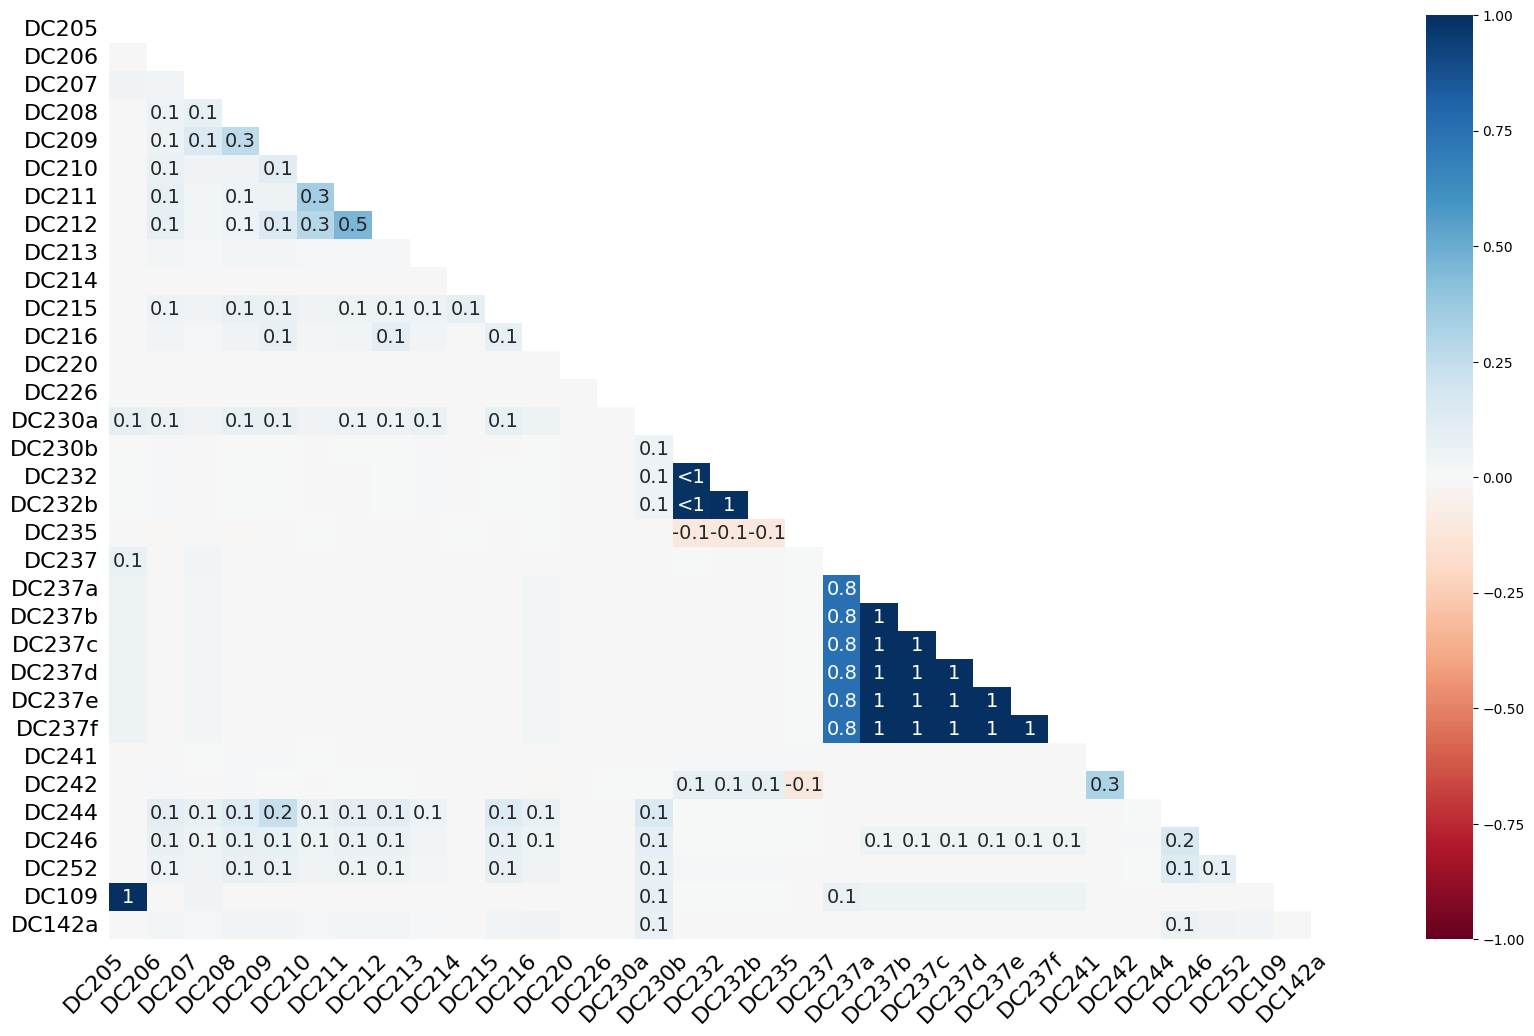

In [ ]:
msno.heatmap(df)

## DC235

Dc235 has the most missing values, perhaps it is not a coincidence?

In [ ]:
df['DC235'].value_counts()

3.0    8811
1.0    8479
2.0    8237
Name: DC235, dtype: int64

#### Analyze correlation with label

No significant difference

In [ ]:
df2 = df[df.isnull().any(axis = 1)]

print('All\n', df[['DC235', 'DC201']].corr())
print('\nMissing Only\n', df2[['DC235', 'DC201']].corr())

All
           DC235     DC201
DC235  1.000000 -0.208762
DC201 -0.208762  1.000000

Missing Only
           DC235     DC201
DC235  1.000000 -0.201397
DC201 -0.201397  1.000000


# Split X y for Training Data

In [ ]:
X = df.drop(['id','DC109', 'DC201'], axis = 1)
y = df['DC201']
X_test = df_test.drop(['DC109', 'id'], axis = 1)
X_test_id = df_test['id']

# Preprocess

## Replace Low Frequency Values with NaN

The idea is that low freq values are just noise.

In [ ]:
threshold = 0.01 # Anything that occurs less than this will be removed.
for col in X.columns:
  value_counts = X[col].value_counts(normalize=True) # Specific column 
  to_remove = value_counts[value_counts <= threshold].index
  X[col].replace(to_remove, np.nan, inplace=True)

## Impute All Missing Values by Iterative Imputer

In [ ]:
imputer = IterativeImputer(random_state=1333, initial_strategy='constant', min_value = 0, verbose = 1)
imputer.set_output(transform = 'pandas')

# transform
X_1 = imputer.fit_transform(X)

## Dimensionality Reduction

In [ ]:
mca = prince.MCA(
    n_components=16,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=323
)

X_2 = mca.fit_transform(X_1)
X_test_2 = mca.transform(X_test)

mca.eigenvalues_summary

## Oversampling (Check Only)

Checking how long oversampling would take. We choose a technique that is fast, but better than Random Sampling.

In [ ]:
# Option 0: ADASYN
adasyn = ADASYN()
X_3, y_3 = adasyn.fit_resample(X_2, y)

In [ ]:
# Option 1: SMOTE Tomek
smote_tomek = SMOTETomek(random_state=1313)
X_3, y_3 = smote_tomek.fit_resample(X_2, y)

In [ ]:
# Option 2: SMOTE-ENN
smote_enn = SMOTEENN(random_state=1213, n_jobs=-1)
X_4, y_4 = smote_enn.fit_resample(X_2, y)

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


# Base Model

Find out which base model perform best and worth tuning.

In [ ]:
def fit_model(x_train, y_train, estimator, cv):
  avg_fit_time = []
  sd_fit_time = []
  max_fit_time = []

  avg_train_score = []
  sd_train_score = []
  max_train_score = []
  min_train_score = []

  avg_test_score = []
  sd_test_score = []
  max_test_score = []
  min_test_score = []
  
  estimator_cv = []

  for est in estimator:
    print('\nCurrent:', est)
    score = cross_validate(est, x_train, y_train, scoring = 'f1', cv = cv, return_train_score=True, return_estimator = True,
                           n_jobs = -1, verbose = 1)
    
    avg_fit_time.append(np.mean(score['fit_time']))
    sd_fit_time.append(np.std(score['fit_time']))
    max_fit_time.append(np.max(score['fit_time']))

    avg_train_score.append(np.mean(score['train_score']))
    sd_train_score.append(np.std(score['train_score']))
    max_train_score.append(np.max(score['train_score']))
    min_train_score.append(np.min(score['train_score']))

    avg_test_score.append(np.mean(score['test_score']))
    sd_test_score.append(np.std(score['test_score']))
    max_test_score.append(np.max(score['test_score']))
    min_test_score.append(np.min(score['test_score']))

    param = []
    for i in score['estimator']:
      param.append(i.get_params())
    
    estimator_cv.append(param)

  result = pd.DataFrame({
    'model' : estimator,
    'avg_fit_time' : avg_fit_time,
    'sd_fit_time' : sd_fit_time,
    'max_fit_time' : max_fit_time,

    'avg_train_score' : avg_train_score,
    'sd_train_score' : sd_train_score,
    'max_train_score' : max_train_score,
    'min_train_score' : min_train_score,

    'avg_test_score' : avg_test_score,
    'sd_test_score' : sd_test_score,
    'max_test_score' : max_test_score,
    'min_test_score' : min_test_score,

    'estimators' : estimator_cv,
  })

  return(result)

In [ ]:
result_mca  = fit_model(X_mca, y_mca, [DecisionTreeClassifier(), RandomForestClassifier(),
                                         SVC(), LGBMClassifier(), CatBoostClassifier(),
                                          HistGradientBoostingClassifier(),
                                         AdaBoostClassifier(), SGDClassifier(),
                                         GaussianNB(), KNeighborsClassifier()])
result_mca

# Tune

In [ ]:
# to add current datetime to submission file.
from datetime import datetime as dt
cdt = dt.today().strftime('%Y-%m-%d')

## Define: Randomized Search CV

In [ ]:
def tune(estimator, param_distribution, X, y, X_test, idcol, modelname = 'Model', cv = StratifiedKFold(5), n_iter = 50):
  cdt = dt.today().strftime('%Y-%m-%d')
  rs = RandomizedSearchCV(
      estimator=estimator,
      param_distributions=param_distribution,
      n_iter=n_iter,
      scoring='f1',
      cv=cv,
      verbose=2,
      random_state=423323,
      n_jobs=-1,
  )

  rs.fit(X, y)
  filename = modelname+'-'+str(cdt)+'-result.csv'
  pd.DataFrame(rs.cv_results_).to_csv(filename, index = False)
  print(rs.best_estimator_)
  
  model = rs.best_estimator_
  cal = CalibratedClassifierCV(model)
  cal.fit(X, y)

  ypred = cal.predict(X_test)
  ypred = ['Layak Minum' if i == 1 else 'Tidak Layak Minum' for i in ypred]
  submission = pd.DataFrame({
      'id' : idcol,
      'DC201' : ypred
  })

  filename = modelname+'-'+str(cdt)+'submission.csv'
  submission.to_csv(filename, index = False)

  return(pd.DataFrame(rs.cv_results_))

## Define: HalvingRandomSearchCV

In [ ]:
def tune_halving(estimator, param_distribution, X, y, X_test, idcol, modelname = 'Model', cv = StratifiedKFold(5), n_iter = 50):
  cdt = dt.today().strftime('%Y-%m-%d')
  rs = HalvingRandomSearchCV(
      estimator=estimator,
      factor = 5,
      param_distributions=param_distribution,
      scoring='f1',
      cv=cv,
      verbose=2,
      random_state=423323,
      n_jobs=-1,
  )

  rs.fit(X, y)
  filename = modelname+'-'+str(cdt)+'-result.csv'
  pd.DataFrame(rs.cv_results_).to_csv(filename, index = False)
  print(rs.best_estimator_)
  
  model = rs.best_estimator_
  cal = CalibratedClassifierCV(model)
  cal.fit(X, y)

  ypred = cal.predict(X_test)
  ypred = ['Layak Minum' if i == 1 else 'Tidak Layak Minum' for i in ypred]
  submission = pd.DataFrame({
      'id' : idcol,
      'DC201' : ypred
  })

  filename = modelname+'-'+str(cdt)+'submission.csv'
  submission.to_csv(filename, index = False)

  return(pd.DataFrame(rs.cv_results_))

## Trial 1 - LightGBM, ADASYN, Randomized Search CV

In [ ]:
# define the parameter distributions to search over
param_distribution1_lgbm = {
    'lgbmclassifier__boosting_type': ['gbdt', 'dart'], #
    'lgbmclassifier__num_leaves': randint(250, 750),
    'lgbmclassifier__max_depth': [-1, 5, 10, 15, 20, 25], #can vary
    'lgbmclassifier__learning_rate': uniform(0.009, 0.21), #
    'lgbmclassifier__n_estimators': randint(50, 350), # can be extended
    'lgbmclassifier__min_child_samples': randint(18, 200),
    'lgbmclassifier__reg_alpha': uniform(4, 4),
    'lgbmclassifier__reg_lambda': uniform(1, 7),
    'lgbmclassifier__colsample_bytree': uniform(0.5, 0.5),
    'lgbmclassifier__subsample': uniform(0.45, 0.55),
    'lgbmclassifier__subsample_freq': randint(1, 10), # can be extended
    'lgbmclassifier__min_split_gain': uniform(0, 1),
    'lgbmclassifier__min_child_weight': uniform(1.5, 8),
    'lgbmclassifier__scale_pos_weight': uniform(0.7, 1.2),
    
}

# create an instance of the LGBMClassifier estimator
estimator_ada = make_pipeline(
    ADASYN(random_state=1313),
    MinMaxScaler(),
    LGBMClassifier(random_state=4244)
)

# create CV instance
my_cv = StratifiedKFold(n_splits=5)

res_lgbm1_ada = tune(estimator_ada, param_distribution1_lgbm, X_2, y, X_test_2, df_test['id'], modelname = 'lgbm_ada', cv = my_cv, n_iter = 100)

## Trial 2 - XGBoost, Random Over Sampler, HalvingRandomSearchCV

In [ ]:
# define the parameter distributions to search over
param_distribution1 = {
    'xgbclassifier__n_estimators': randint(40, 500),
    'xgbclassifier__max_depth': randint(3, 12),
    'xgbclassifier__learning_rate': loguniform(0.01, 0.5),
    'xgbclassifier__gamma': uniform(0, 5),
    'xgbclassifier__subsample': uniform(0.5, 0.5),
    'xgbclassifier__colsample_bytree': uniform(0.5, 0.5),
    'xgbclassifier__reg_alpha': loguniform(1e-5, 1e-1),
    'xgbclassifier__reg_lambda': loguniform(1e-5, 1e-1),
    'xgbclassifier__min_child_weight': randint(1, 3),
}

# create an instance of the XGB estimator
estimator1 = make_pipeline(
    RandomOverSampler(random_state=1313),
    StandardScaler(),
    XGBClassifier()
)

# create CV instance
my_cv = StratifiedKFold(n_splits=5)

res1 = tune_halving(estimator1, param_distribution1, X_2, y, X_test_2, df_test['id'], modelname = 'xgb_random2', cv = my_cv, n_iter = 50)

## Trial 3 - SVM, Random Over Sampling, HalvingRandomSearchCV

In [ ]:
# define the parameter distributions to search over
from sklearn.svm import SVC
param_distribution2 = {
    'svc__C': loguniform(1e-4, 1e4),
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__degree': [2, 3, 4],
    'svc__gamma': ['scale', 'auto', float],
    'svc__coef0': uniform(-1, 1),
    'svc__shrinking': [True, False],
    'svc__probability': [True, False],
    'svc__tol': loguniform(1e-5, 1e-2),
}

# create an instance of the XGB estimator
estimator2 = make_pipeline(
    RandomOverSampler(random_state=1313),
    StandardScaler(),
    SVC(max_iter = 10000)
)

# create CV instance
my_cv = StratifiedKFold(n_splits=5)

res2 = tune_halving(estimator2, param_distribution2, X_2, y, X_test_2, df_test['id'], modelname = 'SVC_random', cv = my_cv, n_iter = 50)

## Trial 4 - Random Forest, Random Over Sampling, HalvingRandomSearchCV

In [ ]:
# define the parameter distributions to search over
param_distribution3 = {
    'randomforestclassifier__n_estimators': randint(100, 1000),
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__min_samples_split': randint(2, 20),
    'randomforestclassifier__min_samples_leaf': randint(1, 10),
    'randomforestclassifier__max_features': ['auto', 'sqrt'],
    'randomforestclassifier__bootstrap': [True, False],
    'randomforestclassifier__class_weight': [None, 'balanced'],
}

# create an instance of the XGB estimator
estimator3 = make_pipeline(
    RandomOverSampler(random_state=1313),
    StandardScaler(),
    RandomForestClassifier()
)

# create CV instance
my_cv = StratifiedKFold(n_splits=5)

res3 = tune(estimator3, param_distribution3, X_2, y, X_test_2, df_test['id'], modelname = 'Randomforest_random', cv = my_cv, n_iter = 50)